In [1]:
"""Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone') 
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')"""
print();

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# count number of nans in a feature
def Find_nans(feature, df):
    return pd.isnull(df[feature]).sum()

# find categorical and numerical columns
def Find_cat_and_num_cols(df):
    categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
    numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
    return categorical_columns, numerical_columns

In [4]:
X = pd.read_csv('train_data.csv')
y = pd.read_csv('train_target.csv')

In [5]:
df = X.copy()
df['y'] = y

In [6]:
cat_feats, num_feats = Find_cat_and_num_cols(df)

# 1. Обзор данных

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,26,student,single,high.school,no,no,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,...,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2,0
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27595 entries, 0 to 27594
Data columns (total 21 columns):
age               27595 non-null int64
job               27595 non-null object
marital           27595 non-null object
education         27595 non-null object
default           27595 non-null object
housing           27595 non-null object
loan              27595 non-null object
contact           27595 non-null object
month             27595 non-null object
day_of_week       27595 non-null object
duration          27595 non-null int64
campaign          27595 non-null int64
pdays             27595 non-null int64
previous          27595 non-null int64
poutcome          27595 non-null object
emp.var.rate      27595 non-null float64
cons.price.idx    27595 non-null float64
cons.conf.idx     27595 non-null float64
euribor3m         27595 non-null float64
nr.employed       27595 non-null float64
y                 27595 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

Типы данных определены верно и соответствуют описаниям признаков.

In [9]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.00000,27595.000000
mean,40.085994,258.874542,2.568328,962.693169,0.172024,0.087211,93.577443,-40.503026,3.628844,5167.31696,0.112847
std,10.480548,260.511236,2.765561,186.371948,0.492548,1.567343,0.578193,4.616641,1.730084,72.22960,0.316411
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.60000,0.000000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.10000,0.000000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.00000,0.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.10000,0.000000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.10000,1.000000


## 1.1. Проверка наличия пропусков и дубликатов

In [10]:
for col in df.columns:
        print("{0}, num. NA's: {1}".format(col, Find_nans(col, df)))

age, num. NA's: 0
job, num. NA's: 0
marital, num. NA's: 0
education, num. NA's: 0
default, num. NA's: 0
housing, num. NA's: 0
loan, num. NA's: 0
contact, num. NA's: 0
month, num. NA's: 0
day_of_week, num. NA's: 0
duration, num. NA's: 0
campaign, num. NA's: 0
pdays, num. NA's: 0
previous, num. NA's: 0
poutcome, num. NA's: 0
emp.var.rate, num. NA's: 0
cons.price.idx, num. NA's: 0
cons.conf.idx, num. NA's: 0
euribor3m, num. NA's: 0
nr.employed, num. NA's: 0
y, num. NA's: 0


Пропущенные значения, к счастью, отсутствуют.

<p> Проверим дубликаты.

In [11]:
l = df.copy()

l['is_duplicated'] = l.duplicated(keep=False)

l[l['is_duplicated'] == True]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_duplicated
3260,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0,True
8010,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,1,True
14313,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,1,True
14559,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0,True
16238,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,True
17473,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0,True
19474,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0,True
23857,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,True


Нашли 4 повторяющихся значений.

In [12]:
df = df.drop_duplicates()

df.shape, l.shape

((27591, 21), (27595, 22))

# 2. Визуализация данных.

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [14]:
pd.value_counts(df['y'])

0    24478
1     3113
Name: y, dtype: int64

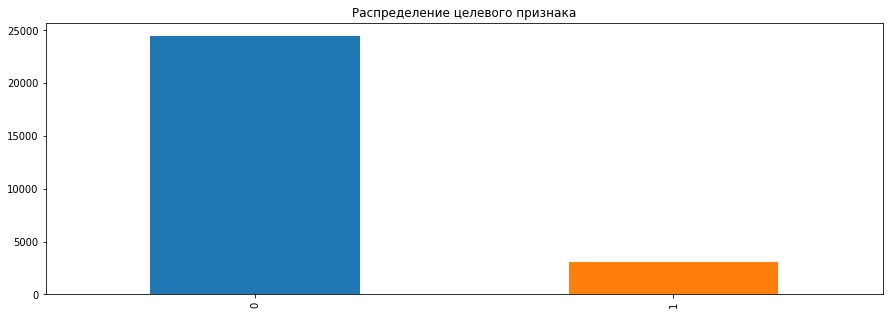

In [15]:
plt.figure(figsize=(15,5))
df['y'].value_counts().plot('bar', label='y')
plt.title('Распределение целевого признака')
plt.show()

Данные оказались несбалансированными. Чаще всего клиенты, к которым банк обращается с предложением по депозиту, не соглашаются на него.

## 2.1. Визуализация распределений признаков.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


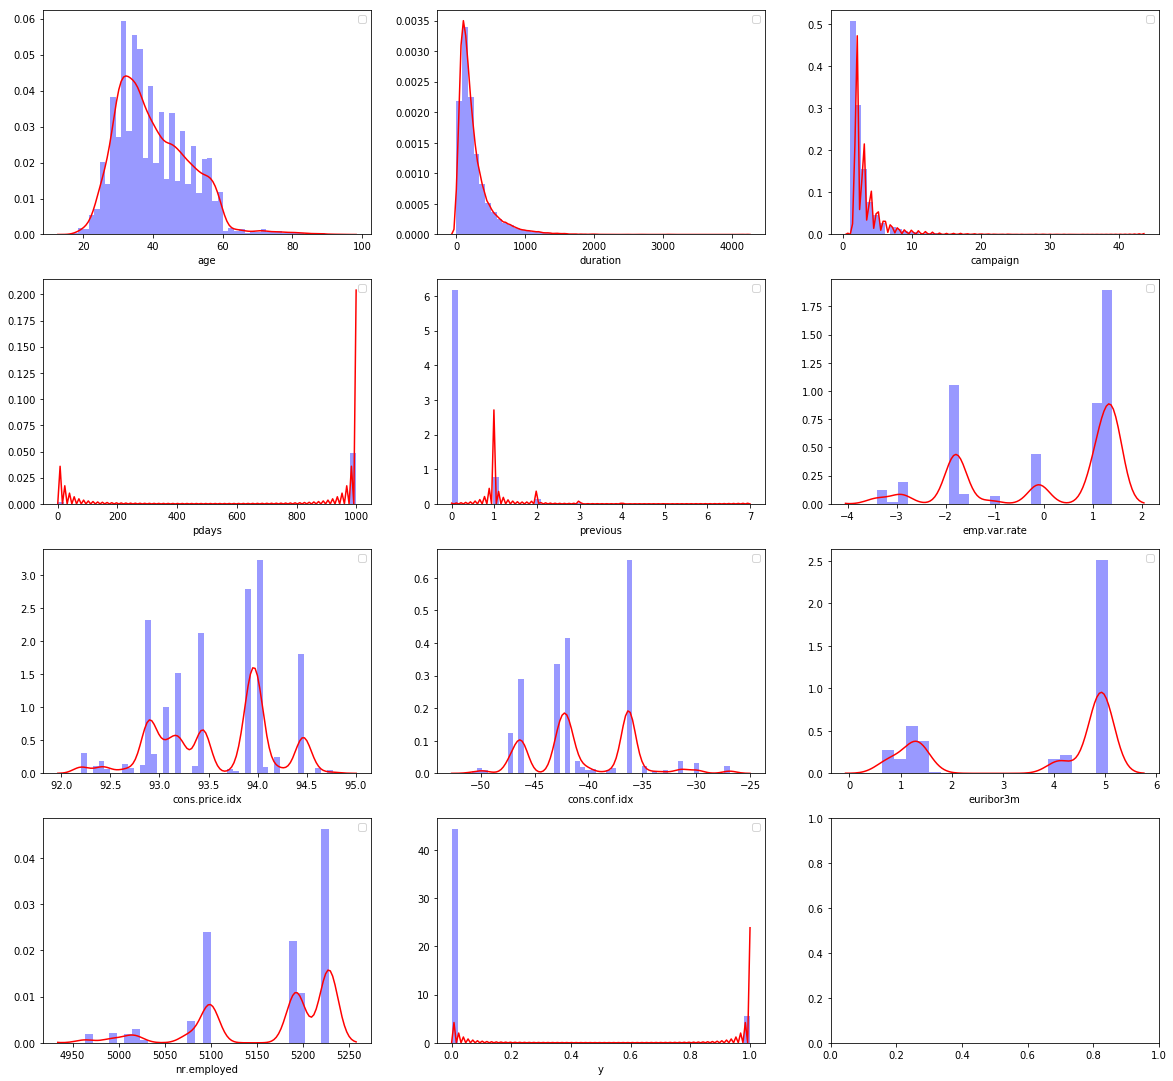

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 19))

for idx, feat in  enumerate(df[num_feats]):
    sns.distplot(df[feat], kde_kws={'color':'r'}, hist_kws={'color':'b'}, ax=axes[int(idx / 3), idx % 3]);
    axes[int(idx / 3), idx % 3].legend()
    axes[int(idx / 3), idx % 3].set_xlabel(feat)

## 2.2. Визуализация зависимости целевого признака от числовых признаков

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


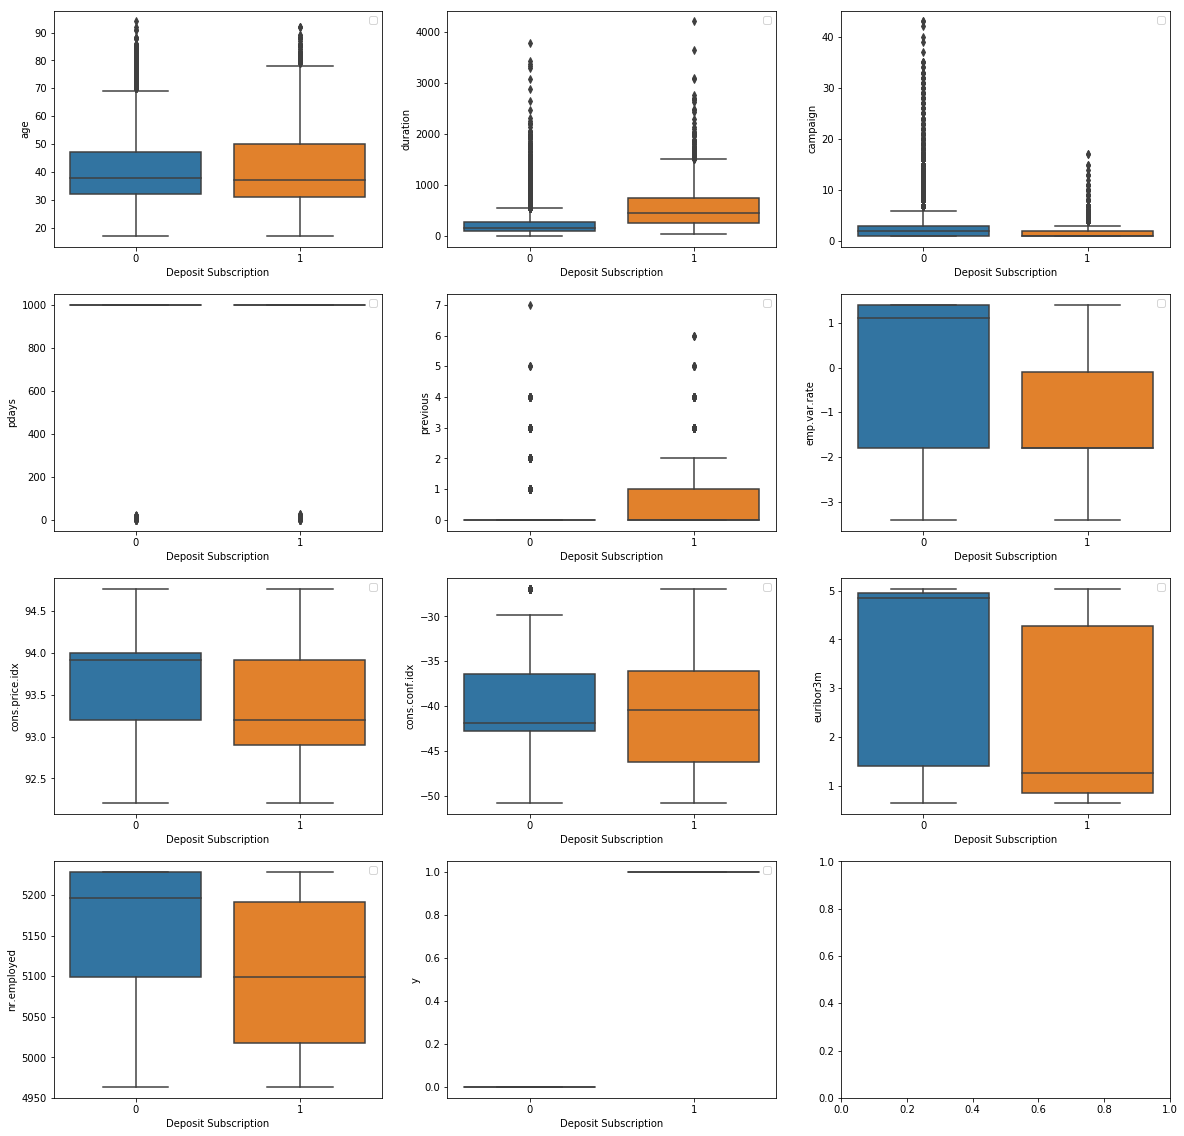

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for idx, feat in  enumerate(df[num_feats]):
    #sns.regplot(x=df.y, y=df[feat], scatter=True, fit_reg=False, ax=axes[int(idx / 3), idx % 3])
    sns.boxplot(x='y', y=feat, data=df, ax=axes[int(idx / 3), idx % 3])
    axes[int(idx / 3), idx % 3].legend()
    axes[int(idx / 3), idx % 3].set_xlabel('Deposit Subscription')
    axes[int(idx / 3), idx % 3].set_ylabel(feat);

# 3. Статистическйи анализ данных

In [18]:
df.describe()[1:]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
mean,40.085898,258.892247,2.568482,962.687905,0.172049,0.087188,93.577443,-40.503266,3.628795,5167.314998,0.112827
std,10.481068,260.524417,2.765712,186.384945,0.492579,1.567302,0.578184,4.616685,1.730088,72.230759,0.316387
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [19]:
df.groupby(['y'])[df.columns[:13]].agg([np.mean, np.std, np.min, np.max])

age                         duration                         \
        mean        std amin amax        mean         std amin  amax   
y                                                                      
0  39.965847   9.957690   17   94  220.970668  208.681325    0  3785   
1  41.029875  13.893187   17   92  557.075490  398.706952   37  4199   

   campaign                           pdays                        
       mean       std amin amax        mean         std amin amax  
y                                                                  
0  2.638941  2.873061    1   43  984.400319  119.502090    0  999  
1  2.014456  1.595135    1   17  791.959846  403.483829    0  999

In [20]:
df.groupby(['y'])[df.columns[14:20]].agg([np.mean, np.std, np.min, np.max])

emp.var.rate                     cons.price.idx                            \
          mean       std amin amax           mean       std    amin    amax   
y                                                                             
0     0.254514  1.478679 -3.4  1.4      93.605635  0.558972  92.201  94.767   
1    -1.228526  1.621278 -3.4  1.4      93.355764  0.671438  92.201  94.767   

  cons.conf.idx                       euribor3m                          \
           mean       std  amin  amax      mean       std   amin   amax   
y                                                                         
0    -40.587372  4.385107 -50.8 -26.9  3.819356  1.632752  0.634  5.045   
1    -39.841921  6.101126 -50.8 -26.9  2.130386  1.742733  0.634  5.045   

   nr.employed                             
          mean        std    amin    amax  
y                                          
0  5176.427682  64.591908  4963.6  5228.1  
1  5095.660553  87.466550  4963.6  5228.1

In [21]:
pair_corr = df.corr(method='spearman')
pair_corr[abs(pair_corr) > 0.3][:-1]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351332
campaign,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,NaN,NaN,NaN,1.00000,-0.509060,NaN,NaN,NaN,NaN,NaN,-0.326677
previous,NaN,NaN,NaN,-0.50906,1.000000,-0.436652,NaN,NaN,-0.456048,-0.440227,NaN
emp.var.rate,NaN,NaN,NaN,NaN,-0.436652,1.000000,0.665589,NaN,0.940278,0.944160,NaN
cons.price.idx,NaN,NaN,NaN,NaN,NaN,0.665589,1.000000,NaN,0.491291,0.463899,NaN
cons.conf.idx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
euribor3m,NaN,NaN,NaN,NaN,-0.456048,0.940278,0.491291,NaN,1.000000,0.928090,NaN
nr.employed,NaN,NaN,NaN,NaN,-0.440227,0.944160,0.463899,NaN,0.928090,1.000000,NaN


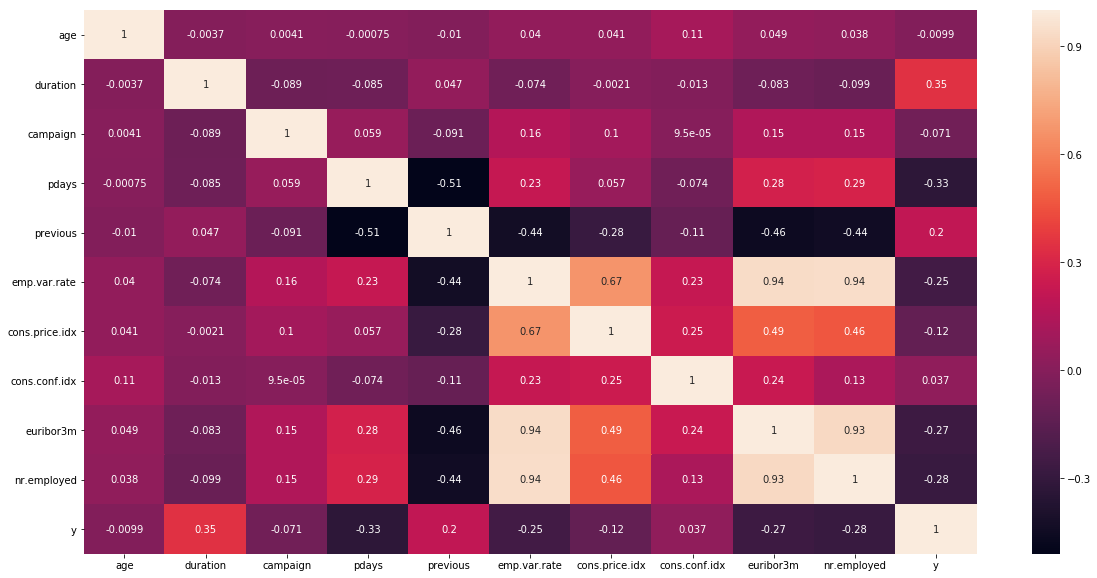

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(pair_corr, annot=True);

In [23]:
pair_corr['y'][:-1]

age              -0.009891
duration          0.351332
campaign         -0.070820
pdays            -0.326677
previous          0.204977
emp.var.rate     -0.248613
cons.price.idx   -0.123317
cons.conf.idx     0.037331
euribor3m        -0.267293
nr.employed      -0.283260
Name: y, dtype: float64

In [24]:
import scipy.stats as stats

In [25]:
df['y'] = df['y'].astype('object')

In [26]:
cat_feats, num_feats = Find_cat_and_num_cols(df)

In [27]:
cramer_table = pd.DataFrame(columns=cat_feats, index=cat_feats)

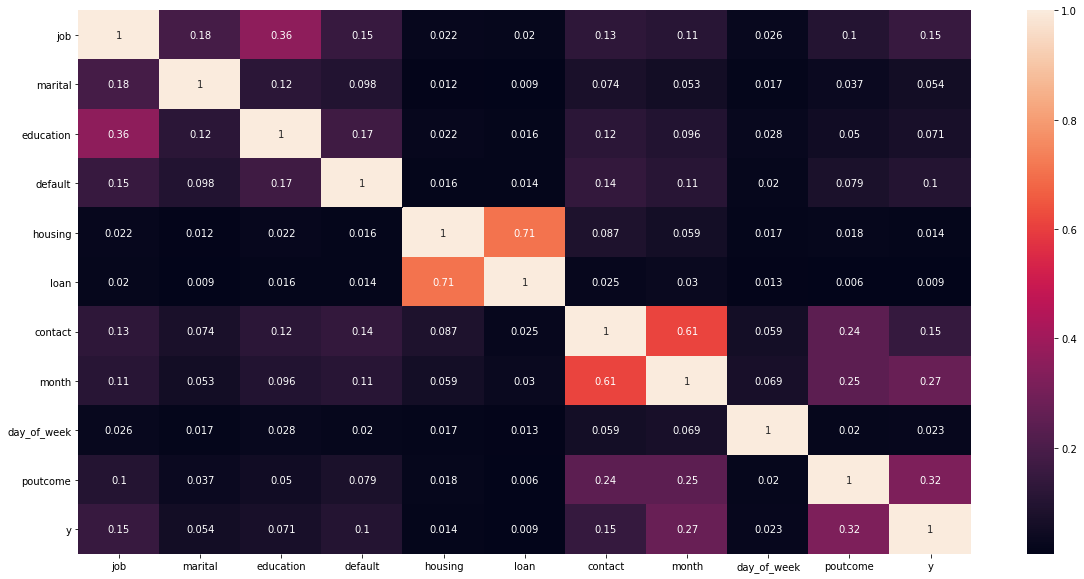

In [28]:
for feature1 in cat_feats:
    for feature2 in cat_feats:
        observed = pd.crosstab(index=df[feature1], columns=df[feature2])
        stat = stats.chi2_contingency(observed=observed)[0]
        V = np.round(sqrt((stat / np.sum(observed.sum().sum())) / (min((observed.shape[0]-1, observed.shape[1]-1)))), 3)
        
        cramer_table[feature1][feature2] = V
        
cramer_table.fillna(value=np.nan, inplace=True)

plt.figure(figsize=(20,10))
sns.heatmap(cramer_table, annot=True)

In [29]:
# cramer_table.to_excel('Таблица Крамера.xlsx')

In [30]:
pd.crosstab(df['poutcome'], df['y'].astype('object'))

y,0,1
poutcome,,
failure,2422,415
nonexistent,21740,2098
success,316,600


In [31]:
pd.crosstab(df['month'], df['y'].astype('object'))

y,0,1
month,,
apr,1383,367
aug,3721,425
dec,65,65
jul,4324,430
jun,3232,390
mar,195,189
may,8533,592
nov,2541,279
oct,275,206


In [32]:
pd.crosstab(df['loan'], df['housing'].astype('object'))

housing,no,unknown,yes
loan,,,
no,10824,0,11935
unknown,0,672,0
yes,1722,0,2438


In [33]:
pd.crosstab(df['education'], df['y'].astype('object'))

y,0,1
education,,
basic.4y,2488,289
basic.6y,1404,121
basic.9y,3757,308
high.school,5713,710
illiterate,8,3
professional.course,3099,402
university.degree,7023,1104
unknown,986,176


In [34]:
pd.crosstab(df['education'], df['job'].astype('object'))

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
education,,,,,,,,,,,,
basic.4y,54,1540,90,324,69,403,61,84,18,35,69,30
basic.6y,103,953,47,53,59,47,13,146,7,59,21,17
basic.9y,323,2428,136,60,120,104,152,275,64,258,125,20
high.school,2235,575,154,124,209,192,78,1838,237,576,178,27
illiterate,0,3,2,1,0,2,3,0,0,0,0,0
professional.course,253,300,88,41,52,179,100,135,32,2206,109,6
university.degree,3852,60,402,85,1394,191,496,122,120,1208,166,31
unknown,175,300,35,30,91,65,19,97,105,144,10,91


In [35]:
pd.crosstab(df['month'], df['contact'].astype('object'))

contact,cellular,telephone
month,,
apr,1621,129
aug,3983,163
dec,107,23
jul,4016,738
jun,559,3063
mar,344,40
may,3627,5498
nov,2541,279
oct,383,98


In [36]:
pd.value_counts(df['month'])

may    9125
jul    4754
aug    4146
jun    3622
nov    2820
apr    1750
oct     481
mar     384
sep     379
dec     130
Name: month, dtype: int64

In [37]:
df['y'] = df['y'].astype('int64')

In [38]:
cat_feats, num_feats = Find_cat_and_cat_feats, num_feats = Find_cat_and_num_cols(df)num_cols(df)

## #4 Моделирование и получение предсказаний

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score,\
        average_precision_score, matthews_corrcoef, recall_score, precision_score

from sklearn import preprocessing
from sklearn.preprocessing import scale, StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import itertools

# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
import catboost as ct

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedKFold


# from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [14]:
classes_names = ['0', '1']

In [15]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def estimate_classification(estimator, X_train, y_train, X_test, y_test, title):
    model = estimator.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8,5))
    plot_confusion_matrix(cm, classes_names, title)
    print('Total correct predictions {0} out of {1}'.format(cm.trace(), X_test.shape[0]))
    print("AUC:", round(roc_auc_score(y_test, predictions, average='micro'),3))
    print(classification_report(y_test, predictions,target_names=classes_names, digits=3))

In [134]:
def qualify_classifier(model, treshold):
    
    prediction = model.predict_proba(X_test)[:,1]
    
    auc_roc = round(roc_auc_score(y_test, prediction),3)
    print("AUC:", auc_roc)
    
    prediction[prediction >= treshold] = 1
    prediction[prediction < treshold] = 0

    precision = round(precision_score(y_test, prediction), 3)
    print("Precision score: ", precision)
    
    recall = round(recall_score(y_test, prediction), 3)
    print("Recall score: ", recall)
    
    f1 = round(f1_score(y_test, prediction), 3)
    print("F1 Score: ", f1)
    
    matthew = round(matthews_corrcoef(y_test, prediction), 3)
    print("Matthews correlation score: ", matthew)
    
    cm = confusion_matrix(y_test, prediction)
    
    plt.figure(figsize=(8,5))
    plot_confusion_matrix(cm, classes_names, 'Confusion Matrix')
    plt.show()
    print('Total correct predictions {0} out of {1}'.format(cm.trace(), X_test.shape[0]))
    print(classification_report(y_test, prediction,target_names=classes_names, digits=3))
    
    return auc_roc, precision, recall, f1, matthew

In [18]:
def show_gs_results(estimator):
    return estimator.grid_scores_, estimator.best_params_, estimator.best_score_

In [19]:
def encode_nominals(columns, data):
    print('Feature encoding started...\n')
    encoder = LabelEncoder()
    for name in columns:
        print('Current name: ', name)
        encoder.fit(data[name].drop_duplicates())
        labels = list(set(encoder.transform(data[name])))
        # work with binary features
        dummy_features = pd.get_dummies(data[name])
        headers = dummy_features.columns.tolist()
        for header in range(len(headers)):
            if (name=='default'):
                headers[header] = 'default_' + headers[header]
            elif (name=='marital'):
                headers[header] = 'marital' + headers[header]
            elif (name=='education'):
                headers[header] = 'education' + headers[header]
            elif (name=='housing'):
                headers[header] = 'housing_' + headers[header]
            elif (name=='loan'):
                headers[header] = 'loan_' + headers[header]
            elif name=='job':
                headers[header] = headers[header] + '_job'
            elif name=='contact':
                headers[header] = headers[header] + '_contact'
            elif name=='month':
                headers[header] = headers[header]
            elif name=='day_of_week':
                headers[header] = headers[header]
            elif name=='poutcome':
                headers[header] = 'poutcome_' + headers[header]
        dummy_features.columns = headers
            # append new features to dataset
        data = data.join(dummy_features)
            # delete encoded feature
        data = data.drop(name, axis=1)
        print("\t Feature '%s' - encoded correctly" % name)
            
    print('\nFeature encoding finished!')
    return data

In [74]:
columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact',
               'month', 'day_of_week','poutcome', 'default']

X[num_feats[:-1]] = StandardScaler().fit_transform(X[num_feats[:-1]])

# encode nominal features
X = encode_nominals(columns, X)

Feature encoding started...

Current name:  job
	 Feature 'job' - encoded correctly
Current name:  marital
	 Feature 'marital' - encoded correctly
Current name:  education
	 Feature 'education' - encoded correctly
Current name:  housing
	 Feature 'housing' - encoded correctly
Current name:  loan
	 Feature 'loan' - encoded correctly
Current name:  contact
	 Feature 'contact' - encoded correctly
Current name:  month
	 Feature 'month' - encoded correctly
Current name:  day_of_week
	 Feature 'day_of_week' - encoded correctly
Current name:  poutcome
	 Feature 'poutcome' - encoded correctly
Current name:  default
	 Feature 'default' - encoded correctly

Feature encoding finished!


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Feature Selection

In [76]:
rf = RandomForestClassifier(n_jobs=-1, random_state=2042).fit(X_train, y_train)

In [78]:
importance = rf.feature_importances_
importances_table = pd.DataFrame(columns=['feature','importance'])
importances_table.feature = X.columns

for i in range(len(importances_table.feature)):
    importances_table.importance[i] = round(importance[i]*100, 2)

importances_table = importances_table.sort_values('importance', ascending=False)

for i in range(len(importances_table.feature)):
    importances_table.importance[i] = str(round(importance[i]*100, 2))+'%'

best_features = list(importances_table.feature.values[:6])

importances_table[:10]

,feature,importance
1,duration,27.65%
8,euribor3m,10.05%
0,age,7.96%
2,campaign,3.75%
59,poutcome_success,3.25%
3,pdays,3.23%
5,emp.var.rate,3.05%
6,cons.price.idx,2.95%
9,nr.employed,2.12%
7,cons.conf.idx,1.53%


Можно сделать вывод, что на исход звонка, в большинстве своем, влияют различные экономические и социальные факторы внутри региона проживания клиента, а также факторы, учитывающие коммуникации с клиентом в ходе предыдущих маркетинговых кампаний.

Обладание данной информацией и ее дальнейшее использование в достаточном объеме позволяет компании прогнозировать вероятность клиента согласиться с условиями рекламного предложения по банковскому депозиту. 

In [79]:
important_features = importances_table[:10]['feature'].values.tolist()

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X[important_features], y, test_size=0.2)

In [81]:
rf = RandomForestClassifier(n_jobs=-1, random_state=2042).fit(X_train, y_train)
qualify_classifier(rf, 0.5);

AUC: 0.91
Precision score:  0.609
Recall score:  0.578
F1 Score:  0.593
Matthews correlation score:  0.542


### NC Models Training

LR
AUC: 0.921
Precision score:  0.655
Recall score:  0.378
F1 Score:  0.479
Matthews correlation score:  0.452


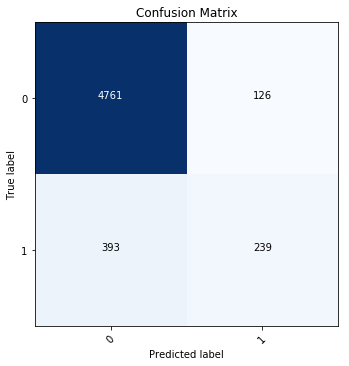

Total correct predictions 5000 out of 5519
             precision    recall  f1-score   support

          0      0.924     0.974     0.948      4887
          1      0.655     0.378     0.479       632

avg / total      0.893     0.906     0.895      5519


SVM
AUC: 0.888
Precision score:  0.668
Recall score:  0.328
F1 Score:  0.439
Matthews correlation score:  0.424


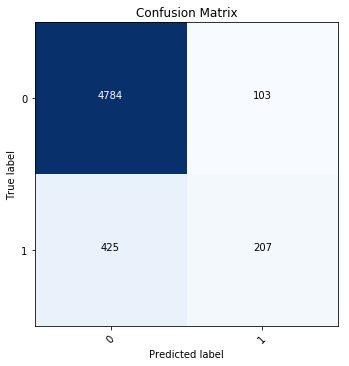

Total correct predictions 4991 out of 5519
             precision    recall  f1-score   support

          0      0.918     0.979     0.948      4887
          1      0.668     0.328     0.439       632

avg / total      0.890     0.904     0.890      5519


KNN
AUC: 0.879
Precision score:  0.599
Recall score:  0.465
F1 Score:  0.524
Matthews correlation score:  0.475


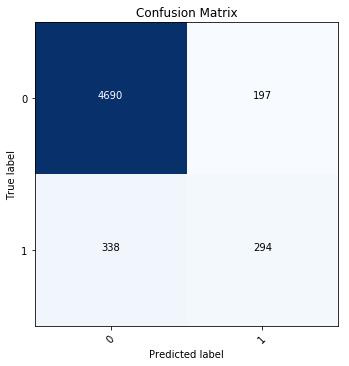

Total correct predictions 4984 out of 5519
             precision    recall  f1-score   support

          0      0.933     0.960     0.946      4887
          1      0.599     0.465     0.524       632

avg / total      0.895     0.903     0.898      5519


DT
AUC: 0.719
Precision score:  0.503
Recall score:  0.502
F1 Score:  0.502
Matthews correlation score:  0.438


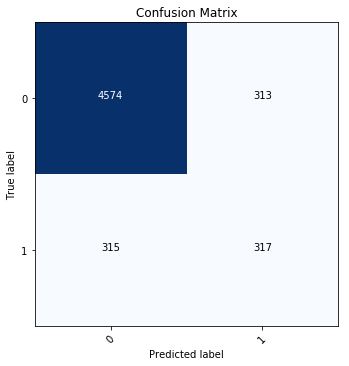

Total correct predictions 4891 out of 5519
             precision    recall  f1-score   support

          0      0.936     0.936     0.936      4887
          1      0.503     0.502     0.502       632

avg / total      0.886     0.886     0.886      5519


RF
AUC: 0.91
Precision score:  0.609
Recall score:  0.578
F1 Score:  0.593
Matthews correlation score:  0.542


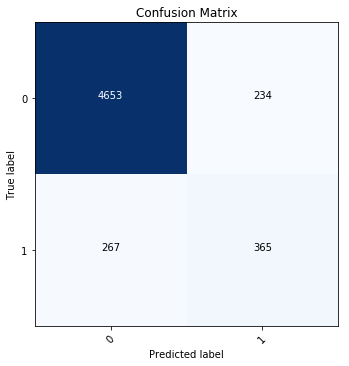

Total correct predictions 5018 out of 5519
             precision    recall  f1-score   support

          0      0.946     0.952     0.949      4887
          1      0.609     0.578     0.593       632

avg / total      0.907     0.909     0.908      5519


GB
AUC: 0.944
Precision score:  0.669
Recall score:  0.509
F1 Score:  0.579
Matthews correlation score:  0.538


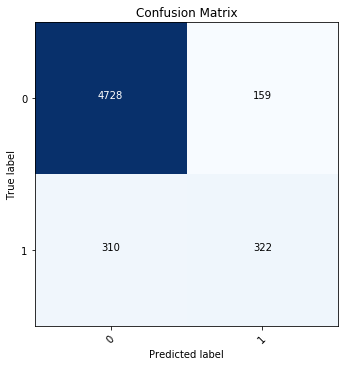

Total correct predictions 5050 out of 5519
             precision    recall  f1-score   support

          0      0.938     0.967     0.953      4887
          1      0.669     0.509     0.579       632

avg / total      0.908     0.915     0.910      5519


CB
0: learn: 0.6554739	total: 48.2ms	remaining: 48.2s
1: learn: 0.6089366	total: 83.8ms	remaining: 41.8s
2: learn: 0.5680606	total: 122ms	remaining: 40.5s
3: learn: 0.535582	total: 167ms	remaining: 41.5s
4: learn: 0.5060359	total: 204ms	remaining: 40.6s
5: learn: 0.4780841	total: 248ms	remaining: 41.2s
6: learn: 0.4481166	total: 286ms	remaining: 40.6s
7: learn: 0.4291908	total: 319ms	remaining: 39.6s
8: learn: 0.4026675	total: 354ms	remaining: 39s
9: learn: 0.383556	total: 395ms	remaining: 39.1s
10: learn: 0.3653089	total: 467ms	remaining: 42s
11: learn: 0.3501864	total: 571ms	remaining: 47s
12: learn: 0.337489	total: 644ms	remaining: 48.9s
13: learn: 0.3256729	total: 697ms	remaining: 49.1s
14: learn: 0.3145785	total: 733ms	remaini

160: learn: 0.1731675	total: 8.65s	remaining: 45.1s
161: learn: 0.1731172	total: 8.69s	remaining: 45s
162: learn: 0.1730489	total: 8.73s	remaining: 44.9s
163: learn: 0.172989	total: 8.78s	remaining: 44.8s
164: learn: 0.1728959	total: 8.84s	remaining: 44.8s
165: learn: 0.172823	total: 8.89s	remaining: 44.7s
166: learn: 0.17269	total: 8.94s	remaining: 44.6s
167: learn: 0.1726038	total: 8.97s	remaining: 44.4s
168: learn: 0.1725519	total: 9.02s	remaining: 44.3s
169: learn: 0.1724396	total: 9.06s	remaining: 44.2s
170: learn: 0.172391	total: 9.11s	remaining: 44.1s
171: learn: 0.1723365	total: 9.16s	remaining: 44.1s
172: learn: 0.1723342	total: 9.19s	remaining: 44s
173: learn: 0.1722851	total: 9.24s	remaining: 43.9s
174: learn: 0.1721739	total: 9.28s	remaining: 43.7s
175: learn: 0.1721238	total: 9.32s	remaining: 43.6s
176: learn: 0.1720651	total: 9.38s	remaining: 43.6s
177: learn: 0.1719658	total: 9.43s	remaining: 43.5s
178: learn: 0.171899	total: 9.49s	remaining: 43.5s
179: learn: 0.1718806	

324: learn: 0.1655492	total: 15.7s	remaining: 32.7s
325: learn: 0.1655039	total: 15.8s	remaining: 32.6s
326: learn: 0.1654914	total: 15.8s	remaining: 32.5s
327: learn: 0.1654551	total: 15.8s	remaining: 32.5s
328: learn: 0.1654001	total: 15.9s	remaining: 32.4s
329: learn: 0.1653744	total: 15.9s	remaining: 32.3s
330: learn: 0.1653447	total: 16s	remaining: 32.3s
331: learn: 0.1653251	total: 16s	remaining: 32.2s
332: learn: 0.165296	total: 16s	remaining: 32.1s
333: learn: 0.1652758	total: 16.1s	remaining: 32.1s
334: learn: 0.1652172	total: 16.1s	remaining: 32s
335: learn: 0.1651974	total: 16.2s	remaining: 31.9s
336: learn: 0.1651511	total: 16.2s	remaining: 31.9s
337: learn: 0.1651333	total: 16.2s	remaining: 31.8s
338: learn: 0.165097	total: 16.3s	remaining: 31.7s
339: learn: 0.1650661	total: 16.3s	remaining: 31.7s
340: learn: 0.1650221	total: 16.4s	remaining: 31.6s
341: learn: 0.1649963	total: 16.4s	remaining: 31.6s
342: learn: 0.1649438	total: 16.4s	remaining: 31.5s
343: learn: 0.1649091	

486: learn: 0.1602476	total: 23s	remaining: 24.2s
487: learn: 0.1602195	total: 23.1s	remaining: 24.2s
488: learn: 0.1602026	total: 23.1s	remaining: 24.1s
489: learn: 0.1601793	total: 23.1s	remaining: 24.1s
490: learn: 0.1601414	total: 23.2s	remaining: 24s
491: learn: 0.1601144	total: 23.2s	remaining: 24s
492: learn: 0.1601009	total: 23.3s	remaining: 23.9s
493: learn: 0.160077	total: 23.3s	remaining: 23.9s
494: learn: 0.1600625	total: 23.3s	remaining: 23.8s
495: learn: 0.1600368	total: 23.4s	remaining: 23.7s
496: learn: 0.1600128	total: 23.4s	remaining: 23.7s
497: learn: 0.1599875	total: 23.4s	remaining: 23.6s
498: learn: 0.1599537	total: 23.5s	remaining: 23.6s
499: learn: 0.1599337	total: 23.5s	remaining: 23.5s
500: learn: 0.1598889	total: 23.5s	remaining: 23.4s
501: learn: 0.1598595	total: 23.6s	remaining: 23.4s
502: learn: 0.1598415	total: 23.6s	remaining: 23.3s
503: learn: 0.1598183	total: 23.6s	remaining: 23.3s
504: learn: 0.1598064	total: 23.7s	remaining: 23.2s
505: learn: 0.15976

807: learn: 0.1528679	total: 35.9s	remaining: 8.54s
808: learn: 0.1528395	total: 36s	remaining: 8.5s
809: learn: 0.1528208	total: 36s	remaining: 8.45s
810: learn: 0.1528044	total: 36.1s	remaining: 8.41s
811: learn: 0.1527871	total: 36.1s	remaining: 8.36s
812: learn: 0.1527679	total: 36.2s	remaining: 8.31s
813: learn: 0.1527499	total: 36.2s	remaining: 8.27s
814: learn: 0.1527405	total: 36.2s	remaining: 8.22s
815: learn: 0.1527194	total: 36.3s	remaining: 8.18s
816: learn: 0.1527086	total: 36.3s	remaining: 8.13s
817: learn: 0.1526995	total: 36.3s	remaining: 8.08s
818: learn: 0.1526887	total: 36.4s	remaining: 8.04s
819: learn: 0.1526692	total: 36.4s	remaining: 7.99s
820: learn: 0.1526456	total: 36.4s	remaining: 7.95s
821: learn: 0.1526304	total: 36.5s	remaining: 7.9s
822: learn: 0.1525996	total: 36.5s	remaining: 7.85s
823: learn: 0.1525578	total: 36.5s	remaining: 7.8s
824: learn: 0.1525476	total: 36.6s	remaining: 7.76s
825: learn: 0.152543	total: 36.6s	remaining: 7.71s
826: learn: 0.152512

967: learn: 0.150061	total: 42.1s	remaining: 1.39s
968: learn: 0.1500487	total: 42.1s	remaining: 1.35s
969: learn: 0.1500465	total: 42.1s	remaining: 1.3s
970: learn: 0.1500238	total: 42.2s	remaining: 1.26s
971: learn: 0.150017	total: 42.2s	remaining: 1.22s
972: learn: 0.1500021	total: 42.2s	remaining: 1.17s
973: learn: 0.1499885	total: 42.3s	remaining: 1.13s
974: learn: 0.1499688	total: 42.3s	remaining: 1.08s
975: learn: 0.1499604	total: 42.4s	remaining: 1.04s
976: learn: 0.1499551	total: 42.4s	remaining: 998ms
977: learn: 0.1499469	total: 42.5s	remaining: 955ms
978: learn: 0.14992	total: 42.5s	remaining: 912ms
979: learn: 0.1499096	total: 42.6s	remaining: 869ms
980: learn: 0.1498938	total: 42.6s	remaining: 826ms
981: learn: 0.1498876	total: 42.7s	remaining: 782ms
982: learn: 0.1498742	total: 42.7s	remaining: 739ms
983: learn: 0.1498541	total: 42.7s	remaining: 695ms
984: learn: 0.1498346	total: 42.8s	remaining: 651ms
985: learn: 0.1498023	total: 42.8s	remaining: 608ms
986: learn: 0.149

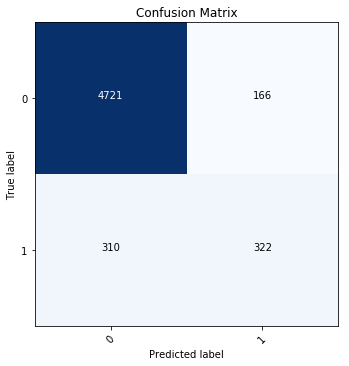

Total correct predictions 5043 out of 5519
             precision    recall  f1-score   support

          0      0.938     0.966     0.952      4887
          1      0.660     0.509     0.575       632

avg / total      0.906     0.914     0.909      5519




,LR,SVM,KNN,DT,RF,GB,CB
AUC ROC,0.921,0.888,0.879,0.719,0.91,0.944,0.947
Precision,0.655,0.668,0.599,0.503,0.609,0.669,0.66
Recall,0.378,0.328,0.465,0.502,0.578,0.509,0.509
F1,0.479,0.439,0.524,0.502,0.593,0.579,0.575
Matthews,0.452,0.424,0.475,0.438,0.542,0.538,0.533


In [135]:
models_quality_table = pd.DataFrame(columns=['LR', 'SVM', 'KNN', 'DT', 'RF', 'GB', 'CB'],\
                                    index = ['AUC ROC', 'Precision', 'Recall', 'F1', 'Matthews'])
models_quality_table

models_dict = {'LR' : LogisticRegression(),
               'SVM' : SVC(probability=True),
               'KNN' : KNeighborsClassifier(),
               'DT' : DecisionTreeClassifier(),
               'RF' : RandomForestClassifier(n_jobs=-1, random_state=2042),
               'GB' : GradientBoostingClassifier(random_state=2042),
               'CB' : CatBoostClassifier() }


for model_name in list(models_dict.keys()):
    
    print(model_name)
    model = models_dict[model_name]
    model = model.fit(X_train, y_train)
    auc, precision, recall, f1, matthews = qualify_classifier(model, 0.5);
    print()
    
    models_quality_table[model_name]['AUC ROC'] = auc
    models_quality_table[model_name]['Precision'] = precision
    models_quality_table[model_name]['Recall'] = recall
    models_quality_table[model_name]['F1'] = f1
    models_quality_table[model_name]['Matthews'] = matthews

models_quality_table

In [136]:
models_quality_table.to_excel('Quality Table - All models - OHE + Scaling (0.5 border).xlsx')

## Configuring GB

In [31]:
gb1 = GradientBoostingClassifier(random_state=20).fit(X_train, y_train)
qualify_classifier(gb1, 0.5);

AUC: 0.947
Precision score:  0.693
Recall score:  0.534
F1 Score:  0.603
Matthews correlation score:  0.567


In [82]:
%%time
gb_param_test1 = {'n_estimators' : np.arange(20, 201, 10) }
gsearch_gb1 = GridSearchCV(GradientBoostingClassifier(), \
                           gb_param_test1, scoring='roc_auc',\
                           cv=5).fit(X_train, y_train.values.reshape(y_train.shape[0], ))

CPU times: user 1min 7s, sys: 463 ms, total: 1min 7s
Wall time: 1min 8s


In [83]:
gsearch_gb1.grid_scores_, gsearch_gb1.best_params_, gsearch_gb1.best_score_

([mean: 0.93557, std: 0.00266, params: {'n_estimators': 20},
  mean: 0.94030, std: 0.00157, params: {'n_estimators': 30},
  mean: 0.94309, std: 0.00162, params: {'n_estimators': 40},
  mean: 0.94410, std: 0.00160, params: {'n_estimators': 50},
  mean: 0.94455, std: 0.00164, params: {'n_estimators': 60},
  mean: 0.94487, std: 0.00169, params: {'n_estimators': 70},
  mean: 0.94509, std: 0.00177, params: {'n_estimators': 80},
  mean: 0.94524, std: 0.00179, params: {'n_estimators': 90},
  mean: 0.94554, std: 0.00162, params: {'n_estimators': 100},
  mean: 0.94575, std: 0.00137, params: {'n_estimators': 110},
  mean: 0.94607, std: 0.00129, params: {'n_estimators': 120},
  mean: 0.94627, std: 0.00120, params: {'n_estimators': 130},
  mean: 0.94625, std: 0.00136, params: {'n_estimators': 140},
  mean: 0.94627, std: 0.00138, params: {'n_estimators': 150},
  mean: 0.94630, std: 0.00142, params: {'n_estimators': 160},
  mean: 0.94648, std: 0.00141, params: {'n_estimators': 170},
  mean: 0.94653,

In [84]:
%%time
gb_param_test2 = {'n_estimators' : np.arange(100, 1001, 200) }
gsearch_gb2 = GridSearchCV(GradientBoostingClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=400,
                                                      max_features='sqrt', subsample=0.8,random_state=2042),
                                                      gb_param_test2,\
                           scoring='roc_auc', cv=5).fit(X_train, y_train.values.reshape(y_train.shape[0], ))

CPU times: user 1min 38s, sys: 497 ms, total: 1min 38s
Wall time: 1min 39s


In [85]:
gsearch_gb2.grid_scores_, gsearch_gb2.best_params_, gsearch_gb2.best_score_

([mean: 0.94737, std: 0.00141, params: {'n_estimators': 100},
  mean: 0.94692, std: 0.00152, params: {'n_estimators': 300},
  mean: 0.94592, std: 0.00151, params: {'n_estimators': 500},
  mean: 0.94501, std: 0.00172, params: {'n_estimators': 700},
  mean: 0.94404, std: 0.00192, params: {'n_estimators': 900}],
 {'n_estimators': 100},
 0.9473721353805596)

In [86]:
%%time
gb_param_test3 = {'min_samples_split' : np.arange(200, 1201, 200),
               'max_depth' : [4, 6, 7, 8]}

gsearch_gb3 = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_features='sqrt',
                                                      subsample=0.8, random_state=2042),
                                                      gb_param_test3, scoring='roc_auc',
                                                      cv=5, n_jobs=-1).fit(X_train, y_train.values.reshape(y_train.shape[0], ))

CPU times: user 1.76 s, sys: 268 ms, total: 2.03 s
Wall time: 36.7 s


In [87]:
gsearch_gb3.grid_scores_, gsearch_gb3.best_params_, gsearch_gb3.best_score_

([mean: 0.94544, std: 0.00163, params: {'max_depth': 4, 'min_samples_split': 200},
  mean: 0.94560, std: 0.00130, params: {'max_depth': 4, 'min_samples_split': 400},
  mean: 0.94553, std: 0.00162, params: {'max_depth': 4, 'min_samples_split': 600},
  mean: 0.94521, std: 0.00114, params: {'max_depth': 4, 'min_samples_split': 800},
  mean: 0.94434, std: 0.00216, params: {'max_depth': 4, 'min_samples_split': 1000},
  mean: 0.94439, std: 0.00210, params: {'max_depth': 4, 'min_samples_split': 1200},
  mean: 0.94624, std: 0.00152, params: {'max_depth': 6, 'min_samples_split': 200},
  mean: 0.94654, std: 0.00129, params: {'max_depth': 6, 'min_samples_split': 400},
  mean: 0.94628, std: 0.00161, params: {'max_depth': 6, 'min_samples_split': 600},
  mean: 0.94621, std: 0.00136, params: {'max_depth': 6, 'min_samples_split': 800},
  mean: 0.94620, std: 0.00165, params: {'max_depth': 6, 'min_samples_split': 1000},
  mean: 0.94616, std: 0.00154, params: {'max_depth': 6, 'min_samples_split': 1200},


In [88]:
%%time
gb_param_test4 = {'min_samples_leaf' : np.arange(30, 151, 20)}

gsearch_gb4 = GridSearchCV(GradientBoostingClassifier(n_estimators=200, max_features='sqrt', max_depth=8,
                                                      min_samples_split=600, subsample=0.8,
                                                      random_state=2042),gb_param_test4,
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train.values.reshape(y_train.shape[0], ))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   23.6s finished


CPU times: user 2.29 s, sys: 102 ms, total: 2.39 s
Wall time: 25.9 s


In [89]:
gsearch_gb4.grid_scores_, gsearch_gb4.best_params_, gsearch_gb4.best_score_

([mean: 0.94688, std: 0.00143, params: {'min_samples_leaf': 30},
  mean: 0.94689, std: 0.00114, params: {'min_samples_leaf': 50},
  mean: 0.94674, std: 0.00139, params: {'min_samples_leaf': 70},
  mean: 0.94688, std: 0.00132, params: {'min_samples_leaf': 90},
  mean: 0.94709, std: 0.00139, params: {'min_samples_leaf': 110},
  mean: 0.94696, std: 0.00115, params: {'min_samples_leaf': 130},
  mean: 0.94687, std: 0.00147, params: {'min_samples_leaf': 150}],
 {'min_samples_leaf': 110},
 0.9470919194395788)

In [90]:
%%time
gb_param_test5 = {'subsample' : [0.6, 0.7, 0.75, 0.8, 0.85]}

gsearch_gb5 = GridSearchCV(GradientBoostingClassifier(n_estimators=200, max_depth=8, min_samples_leaf=110,
                                                    min_samples_split=600, max_features='sqrt', random_state=2042),
                                                      gb_param_test5, scoring='roc_auc',
                           cv=5, n_jobs=-1).fit(X_train, y_train.values.reshape(y_train.shape[0], ))

CPU times: user 2.32 s, sys: 88.9 ms, total: 2.41 s
Wall time: 19.7 s


In [91]:
gsearch_gb5.grid_scores_, gsearch_gb5.best_params_, gsearch_gb5.best_score_

([mean: 0.94692, std: 0.00145, params: {'subsample': 0.6},
  mean: 0.94677, std: 0.00117, params: {'subsample': 0.7},
  mean: 0.94674, std: 0.00141, params: {'subsample': 0.75},
  mean: 0.94709, std: 0.00139, params: {'subsample': 0.8},
  mean: 0.94684, std: 0.00159, params: {'subsample': 0.85}],
 {'subsample': 0.8},
 0.9470919194395788)

In [96]:
%%time
tuned_gb1 = GradientBoostingClassifier(n_estimators=600, max_depth=8, min_samples_leaf=110, learning_rate=0.1,
                                                    min_samples_split=600, max_features='sqrt',
                                       random_state=2042, subsample=0.8).fit(X_train, y_train)

CPU times: user 5.75 s, sys: 36.6 ms, total: 5.79 s
Wall time: 5.83 s


In [115]:
%%time
tuned_gb1 = GradientBoostingClassifier(random_state=1).fit(X_train, y_train)

CPU times: user 844 ms, sys: 8.64 ms, total: 853 ms
Wall time: 858 ms


In [116]:
qualify_classifier(tuned_gb1, 0.5);

AUC: 0.944
Precision score:  0.67
Recall score:  0.511
F1 Score:  0.58
Matthews correlation score:  0.54


## Catboost testing without one-hot-encoding

In [33]:
X = pd.read_csv('train_data.csv')
y = pd.read_csv('train_target.csv')

X[num_feats[:-1]] = StandardScaler().fit_transform(X[num_feats[:-1]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
cat_features_indices = list(np.where(X_train.dtypes == 'object')[0])
cat_features_indices = [int(elem) for elem in cat_features_indices]

In [56]:
catboost_clf = CatBoostClassifier(calc_feature_importance=True, use_best_model=True, eval_metric='AUC').fit(X_train, y_train,\
                                  eval_set = (X_test, y_test), cat_features=cat_features_indices, verbose=False)

0: learn: 0.9160916	test: 0.9172277	bestTest: 0.9172277 (0)	total: 54.9ms	remaining: 54.9s
1: learn: 0.9182853	test: 0.9150028	bestTest: 0.9172277 (0)	total: 105ms	remaining: 52.5s
2: learn: 0.9207837	test: 0.9193469	bestTest: 0.9193469 (2)	total: 156ms	remaining: 51.9s
3: learn: 0.9240922	test: 0.9233621	bestTest: 0.9233621 (3)	total: 207ms	remaining: 51.6s
4: learn: 0.9239198	test: 0.9227903	bestTest: 0.9233621 (3)	total: 263ms	remaining: 52.3s
5: learn: 0.9227512	test: 0.9219326	bestTest: 0.9233621 (3)	total: 312ms	remaining: 51.8s
6: learn: 0.9245261	test: 0.92377	bestTest: 0.92377 (6)	total: 363ms	remaining: 51.5s
7: learn: 0.9258497	test: 0.9255346	bestTest: 0.9255346 (7)	total: 415ms	remaining: 51.5s
8: learn: 0.9274287	test: 0.927838	bestTest: 0.927838 (8)	total: 469ms	remaining: 51.7s
9: learn: 0.9285676	test: 0.9286454	bestTest: 0.9286454 (9)	total: 581ms	remaining: 57.5s
10: learn: 0.9302012	test: 0.9294962	bestTest: 0.9294962 (10)	total: 634ms	remaining: 57s
11: learn: 0.93

91: learn: 0.9465136	test: 0.9441288	bestTest: 0.9441288 (91)	total: 5.22s	remaining: 51.5s
92: learn: 0.9466092	test: 0.9442337	bestTest: 0.9442337 (92)	total: 5.28s	remaining: 51.5s
93: learn: 0.9466721	test: 0.9442208	bestTest: 0.9442337 (92)	total: 5.33s	remaining: 51.4s
94: learn: 0.9467273	test: 0.9442629	bestTest: 0.9442629 (94)	total: 5.38s	remaining: 51.2s
95: learn: 0.9468489	test: 0.9443443	bestTest: 0.9443443 (95)	total: 5.43s	remaining: 51.1s
96: learn: 0.946919	test: 0.9443562	bestTest: 0.9443562 (96)	total: 5.48s	remaining: 51.1s
97: learn: 0.9470142	test: 0.9444557	bestTest: 0.9444557 (97)	total: 5.53s	remaining: 50.9s
98: learn: 0.9470886	test: 0.9444789	bestTest: 0.9444789 (98)	total: 5.58s	remaining: 50.8s
99: learn: 0.9471246	test: 0.9444991	bestTest: 0.9444991 (99)	total: 5.63s	remaining: 50.7s
100: learn: 0.9472534	test: 0.9446411	bestTest: 0.9446411 (100)	total: 5.69s	remaining: 50.6s
101: learn: 0.9473153	test: 0.9446925	bestTest: 0.9446925 (101)	total: 5.74s	re

182: learn: 0.9514354	test: 0.9471838	bestTest: 0.9471838 (182)	total: 9.96s	remaining: 44.4s
183: learn: 0.9515078	test: 0.9472225	bestTest: 0.9472225 (183)	total: 10s	remaining: 44.4s
184: learn: 0.9515416	test: 0.9472566	bestTest: 0.9472566 (184)	total: 10.1s	remaining: 44.3s
185: learn: 0.951567	test: 0.9472944	bestTest: 0.9472944 (185)	total: 10.1s	remaining: 44.3s
186: learn: 0.9516167	test: 0.9473292	bestTest: 0.9473292 (186)	total: 10.2s	remaining: 44.2s
187: learn: 0.9516338	test: 0.9473328	bestTest: 0.9473328 (187)	total: 10.2s	remaining: 44.2s
188: learn: 0.9516782	test: 0.9473411	bestTest: 0.9473411 (188)	total: 10.3s	remaining: 44.1s
189: learn: 0.951679	test: 0.9473341	bestTest: 0.9473411 (188)	total: 10.3s	remaining: 44s
190: learn: 0.9516955	test: 0.947305	bestTest: 0.9473411 (188)	total: 10.4s	remaining: 43.9s
191: learn: 0.9517453	test: 0.9472997	bestTest: 0.9473411 (188)	total: 10.4s	remaining: 43.9s
192: learn: 0.9517629	test: 0.9472934	bestTest: 0.9473411 (188)	tot

271: learn: 0.9542952	test: 0.9484168	bestTest: 0.9484168 (271)	total: 14.6s	remaining: 39s
272: learn: 0.9543208	test: 0.94844	bestTest: 0.94844 (272)	total: 14.6s	remaining: 39s
273: learn: 0.9543404	test: 0.9484622	bestTest: 0.9484622 (273)	total: 14.7s	remaining: 38.9s
274: learn: 0.9544164	test: 0.9485059	bestTest: 0.9485059 (274)	total: 14.7s	remaining: 38.8s
275: learn: 0.9544622	test: 0.9485185	bestTest: 0.9485185 (275)	total: 14.8s	remaining: 38.8s
276: learn: 0.9545179	test: 0.9485486	bestTest: 0.9485486 (276)	total: 14.8s	remaining: 38.7s
277: learn: 0.9546093	test: 0.9486012	bestTest: 0.9486012 (277)	total: 14.9s	remaining: 38.7s
278: learn: 0.9546239	test: 0.9485923	bestTest: 0.9486012 (277)	total: 15s	remaining: 38.8s
279: learn: 0.954681	test: 0.9486075	bestTest: 0.9486075 (279)	total: 15.1s	remaining: 38.8s
280: learn: 0.9547169	test: 0.9486201	bestTest: 0.9486201 (280)	total: 15.1s	remaining: 38.7s
281: learn: 0.9547521	test: 0.9486476	bestTest: 0.9486476 (281)	total: 

360: learn: 0.9570361	test: 0.9492634	bestTest: 0.9492658 (358)	total: 19.4s	remaining: 34.4s
361: learn: 0.9570971	test: 0.9493207	bestTest: 0.9493207 (361)	total: 19.5s	remaining: 34.3s
362: learn: 0.9571371	test: 0.9493128	bestTest: 0.9493207 (361)	total: 19.5s	remaining: 34.3s
363: learn: 0.9571543	test: 0.9493177	bestTest: 0.9493207 (361)	total: 19.6s	remaining: 34.2s
364: learn: 0.957165	test: 0.9493101	bestTest: 0.9493207 (361)	total: 19.6s	remaining: 34.1s
365: learn: 0.9571876	test: 0.9493138	bestTest: 0.9493207 (361)	total: 19.7s	remaining: 34.1s
366: learn: 0.9571978	test: 0.9493201	bestTest: 0.9493207 (361)	total: 19.7s	remaining: 34.1s
367: learn: 0.9572206	test: 0.9493154	bestTest: 0.9493207 (361)	total: 19.8s	remaining: 34s
368: learn: 0.9572643	test: 0.9493465	bestTest: 0.9493465 (368)	total: 19.9s	remaining: 34s
369: learn: 0.9572796	test: 0.9493648	bestTest: 0.9493648 (369)	total: 19.9s	remaining: 33.9s
370: learn: 0.9573007	test: 0.9493667	bestTest: 0.9493667 (370)	t

450: learn: 0.9593036	test: 0.9497657	bestTest: 0.9497823 (447)	total: 24.6s	remaining: 30s
451: learn: 0.9593244	test: 0.9497806	bestTest: 0.9497823 (447)	total: 24.7s	remaining: 29.9s
452: learn: 0.9593662	test: 0.949774	bestTest: 0.9497823 (447)	total: 24.7s	remaining: 29.9s
453: learn: 0.9593814	test: 0.949774	bestTest: 0.9497823 (447)	total: 24.8s	remaining: 29.8s
454: learn: 0.9593893	test: 0.9497756	bestTest: 0.9497823 (447)	total: 24.9s	remaining: 29.8s
455: learn: 0.9594457	test: 0.9498425	bestTest: 0.9498425 (455)	total: 24.9s	remaining: 29.7s
456: learn: 0.9594755	test: 0.9498445	bestTest: 0.9498445 (456)	total: 25s	remaining: 29.7s
457: learn: 0.9595324	test: 0.9498508	bestTest: 0.9498508 (457)	total: 25s	remaining: 29.6s
458: learn: 0.9595512	test: 0.9498548	bestTest: 0.9498548 (458)	total: 25.1s	remaining: 29.6s
459: learn: 0.9595883	test: 0.9498521	bestTest: 0.9498548 (458)	total: 25.2s	remaining: 29.5s
460: learn: 0.9596011	test: 0.9498415	bestTest: 0.9498548 (458)	tota

539: learn: 0.9613649	test: 0.9500293	bestTest: 0.9500846 (525)	total: 29.7s	remaining: 25.3s
540: learn: 0.9613856	test: 0.9500584	bestTest: 0.9500846 (525)	total: 29.7s	remaining: 25.2s
541: learn: 0.9614003	test: 0.9500667	bestTest: 0.9500846 (525)	total: 29.8s	remaining: 25.2s
542: learn: 0.9614122	test: 0.9500644	bestTest: 0.9500846 (525)	total: 29.8s	remaining: 25.1s
543: learn: 0.9614428	test: 0.9500548	bestTest: 0.9500846 (525)	total: 29.9s	remaining: 25.1s
544: learn: 0.9614582	test: 0.9500419	bestTest: 0.9500846 (525)	total: 29.9s	remaining: 25s
545: learn: 0.9614723	test: 0.9500554	bestTest: 0.9500846 (525)	total: 30s	remaining: 24.9s
546: learn: 0.9614958	test: 0.9500385	bestTest: 0.9500846 (525)	total: 30.1s	remaining: 24.9s
547: learn: 0.9615165	test: 0.9500197	bestTest: 0.9500846 (525)	total: 30.1s	remaining: 24.8s
548: learn: 0.9615308	test: 0.950021	bestTest: 0.9500846 (525)	total: 30.2s	remaining: 24.8s
549: learn: 0.9615395	test: 0.9500402	bestTest: 0.9500846 (525)	t

627: learn: 0.9631927	test: 0.9501836	bestTest: 0.9501902 (619)	total: 34.7s	remaining: 20.5s
628: learn: 0.9632076	test: 0.9501951	bestTest: 0.9501951 (628)	total: 34.7s	remaining: 20.5s
629: learn: 0.9632283	test: 0.9502114	bestTest: 0.9502114 (629)	total: 34.8s	remaining: 20.4s
630: learn: 0.963241	test: 0.9502091	bestTest: 0.9502114 (629)	total: 34.8s	remaining: 20.4s
631: learn: 0.9632607	test: 0.9502276	bestTest: 0.9502276 (631)	total: 34.9s	remaining: 20.3s
632: learn: 0.9632744	test: 0.9502302	bestTest: 0.9502302 (632)	total: 34.9s	remaining: 20.3s
633: learn: 0.9632951	test: 0.9502485	bestTest: 0.9502485 (633)	total: 35s	remaining: 20.2s
634: learn: 0.9632984	test: 0.9502392	bestTest: 0.9502485 (633)	total: 35s	remaining: 20.1s
635: learn: 0.9633116	test: 0.950219	bestTest: 0.9502485 (633)	total: 35.1s	remaining: 20.1s
636: learn: 0.9633174	test: 0.9502243	bestTest: 0.9502485 (633)	total: 35.1s	remaining: 20s
637: learn: 0.9633528	test: 0.9502428	bestTest: 0.9502485 (633)	tota

717: learn: 0.9648105	test: 0.9504561	bestTest: 0.9504885 (712)	total: 39.6s	remaining: 15.5s
718: learn: 0.9648392	test: 0.9504604	bestTest: 0.9504885 (712)	total: 39.6s	remaining: 15.5s
719: learn: 0.9648537	test: 0.9504425	bestTest: 0.9504885 (712)	total: 39.7s	remaining: 15.4s
720: learn: 0.9648905	test: 0.9504405	bestTest: 0.9504885 (712)	total: 39.7s	remaining: 15.4s
721: learn: 0.9649084	test: 0.9504342	bestTest: 0.9504885 (712)	total: 39.8s	remaining: 15.3s
722: learn: 0.9649348	test: 0.9504104	bestTest: 0.9504885 (712)	total: 39.8s	remaining: 15.3s
723: learn: 0.9649664	test: 0.9503981	bestTest: 0.9504885 (712)	total: 39.9s	remaining: 15.2s
724: learn: 0.9649795	test: 0.9504057	bestTest: 0.9504885 (712)	total: 39.9s	remaining: 15.2s
725: learn: 0.9650198	test: 0.9504107	bestTest: 0.9504885 (712)	total: 40s	remaining: 15.1s
726: learn: 0.9650453	test: 0.9504491	bestTest: 0.9504885 (712)	total: 40s	remaining: 15s
727: learn: 0.9650531	test: 0.9504395	bestTest: 0.9504885 (712)	to

805: learn: 0.9661367	test: 0.9505418	bestTest: 0.9505623 (780)	total: 44.3s	remaining: 10.7s
806: learn: 0.9661485	test: 0.9505372	bestTest: 0.9505623 (780)	total: 44.4s	remaining: 10.6s
807: learn: 0.9661561	test: 0.9505352	bestTest: 0.9505623 (780)	total: 44.4s	remaining: 10.6s
808: learn: 0.9661734	test: 0.9505494	bestTest: 0.9505623 (780)	total: 44.5s	remaining: 10.5s
809: learn: 0.9661791	test: 0.9505481	bestTest: 0.9505623 (780)	total: 44.5s	remaining: 10.4s
810: learn: 0.9661939	test: 0.9505511	bestTest: 0.9505623 (780)	total: 44.6s	remaining: 10.4s
811: learn: 0.9662064	test: 0.9505494	bestTest: 0.9505623 (780)	total: 44.6s	remaining: 10.3s
812: learn: 0.9662216	test: 0.9505302	bestTest: 0.9505623 (780)	total: 44.7s	remaining: 10.3s
813: learn: 0.9662198	test: 0.9505249	bestTest: 0.9505623 (780)	total: 44.7s	remaining: 10.2s
814: learn: 0.9662339	test: 0.9505289	bestTest: 0.9505623 (780)	total: 44.8s	remaining: 10.2s
815: learn: 0.9662428	test: 0.950517	bestTest: 0.9505623 (78

894: learn: 0.9673949	test: 0.9506901	bestTest: 0.9507153 (884)	total: 49s	remaining: 5.74s
895: learn: 0.9674156	test: 0.9507113	bestTest: 0.9507153 (884)	total: 49s	remaining: 5.69s
896: learn: 0.9674194	test: 0.950712	bestTest: 0.9507153 (884)	total: 49.1s	remaining: 5.63s
897: learn: 0.9674473	test: 0.9507199	bestTest: 0.9507199 (897)	total: 49.1s	remaining: 5.58s
898: learn: 0.9674496	test: 0.950715	bestTest: 0.9507199 (897)	total: 49.2s	remaining: 5.53s
899: learn: 0.967453	test: 0.9507166	bestTest: 0.9507199 (897)	total: 49.2s	remaining: 5.47s
900: learn: 0.9674717	test: 0.9507024	bestTest: 0.9507199 (897)	total: 49.3s	remaining: 5.42s
901: learn: 0.9674836	test: 0.9507014	bestTest: 0.9507199 (897)	total: 49.4s	remaining: 5.36s
902: learn: 0.9674891	test: 0.9506971	bestTest: 0.9507199 (897)	total: 49.4s	remaining: 5.31s
903: learn: 0.9674953	test: 0.9506991	bestTest: 0.9507199 (897)	total: 49.5s	remaining: 5.25s
904: learn: 0.9675045	test: 0.9507047	bestTest: 0.9507199 (897)	tot

985: learn: 0.9684614	test: 0.9507236	bestTest: 0.9507673 (925)	total: 54.8s	remaining: 779ms
986: learn: 0.968471	test: 0.950717	bestTest: 0.9507673 (925)	total: 54.9s	remaining: 723ms
987: learn: 0.9684845	test: 0.9507415	bestTest: 0.9507673 (925)	total: 55s	remaining: 667ms
988: learn: 0.9685006	test: 0.9507299	bestTest: 0.9507673 (925)	total: 55s	remaining: 612ms
989: learn: 0.9685179	test: 0.950715	bestTest: 0.9507673 (925)	total: 55.1s	remaining: 556ms
990: learn: 0.9685253	test: 0.9507031	bestTest: 0.9507673 (925)	total: 55.1s	remaining: 501ms
991: learn: 0.9685359	test: 0.9507196	bestTest: 0.9507673 (925)	total: 55.2s	remaining: 445ms
992: learn: 0.9685537	test: 0.950716	bestTest: 0.9507673 (925)	total: 55.3s	remaining: 390ms
993: learn: 0.9685542	test: 0.9507186	bestTest: 0.9507673 (925)	total: 55.4s	remaining: 334ms
994: learn: 0.9685681	test: 0.9507206	bestTest: 0.9507673 (925)	total: 55.4s	remaining: 278ms
995: learn: 0.9685783	test: 0.9507153	bestTest: 0.9507673 (925)	tota

In [57]:
qualify_classifier(catboost_clf, 0.5);

AUC: 0.951
Precision score:  0.669
Recall score:  0.549
F1 Score:  0.603
Matthews correlation score:  0.562


После обучения алгоритма catboost без предварительного кодирования категориальных признаков можно сделать следующие выводы о важности имеющихся признаков:

1. На исход звонка, в большинстве своем, все также влияют различные экономические и социальные факторы (euribor3m, nr.employed, emp.var.rate) внутри региона проживания клиента, а также факторы, учитывающие коммуникации с клиентом в ходе предыдущих маркетинговых кампаний.

2. Как и предполагалось, длительность общения клиента с экспертом телемаркетингового отдела является одним из главных и определяющих признаков, влияние которого на итоговый результат велико.

In [67]:
X = pd.read_csv('train_data.csv')
y = pd.read_csv('train_target.csv')

X[num_feats[:-1]] = StandardScaler().fit_transform(X[num_feats[:-1]])

X_train, X_test, y_train, y_test = train_test_split(X[important_features], y, test_size=0.2)

In [68]:
cat_features_indices = list(np.where(X_train.dtypes == 'object')[0])
cat_features_indices = [int(elem) for elem in cat_features_indices]

In [69]:
catboost_clf = CatBoostClassifier(calc_feature_importance=True, use_best_model=True, eval_metric='AUC').fit(X_train, y_train,\
                                  eval_set = (X_test, y_test), cat_features=cat_features_indices, verbose=False)

0: learn: 0.6538448	test: 0.6570086	bestTest: 0.6570086 (0)	total: 75.3ms	remaining: 1m 15s
1: learn: 0.658835	test: 0.6675781	bestTest: 0.6675781 (1)	total: 124ms	remaining: 1m 2s
2: learn: 0.6660588	test: 0.6632342	bestTest: 0.6675781 (1)	total: 184ms	remaining: 1m 1s
3: learn: 0.6807648	test: 0.6863818	bestTest: 0.6863818 (3)	total: 250ms	remaining: 1m 2s
4: learn: 0.6816334	test: 0.6872836	bestTest: 0.6872836 (4)	total: 309ms	remaining: 1m 1s
5: learn: 0.6928369	test: 0.692253	bestTest: 0.692253 (5)	total: 371ms	remaining: 1m 1s
6: learn: 0.6945148	test: 0.6966929	bestTest: 0.6966929 (6)	total: 428ms	remaining: 1m
7: learn: 0.7218216	test: 0.7267896	bestTest: 0.7267896 (7)	total: 498ms	remaining: 1m 1s
8: learn: 0.7232032	test: 0.7285269	bestTest: 0.7285269 (8)	total: 572ms	remaining: 1m 2s
9: learn: 0.7222463	test: 0.7283567	bestTest: 0.7285269 (8)	total: 639ms	remaining: 1m 3s
10: learn: 0.7279643	test: 0.73317	bestTest: 0.73317 (10)	total: 698ms	remaining: 1m 2s
11: learn: 0.728

178: learn: 0.7587457	test: 0.7550426	bestTest: 0.7550917 (158)	total: 11.6s	remaining: 53.2s
179: learn: 0.7587948	test: 0.7551418	bestTest: 0.7551418 (179)	total: 11.7s	remaining: 53.1s
180: learn: 0.7588631	test: 0.7551113	bestTest: 0.7551418 (179)	total: 11.7s	remaining: 53.1s
181: learn: 0.7588645	test: 0.7551113	bestTest: 0.7551418 (179)	total: 11.8s	remaining: 52.9s
182: learn: 0.7588645	test: 0.7551113	bestTest: 0.7551418 (179)	total: 11.8s	remaining: 52.7s
183: learn: 0.7589642	test: 0.7551511	bestTest: 0.7551511 (183)	total: 11.9s	remaining: 52.6s
184: learn: 0.7589645	test: 0.7551611	bestTest: 0.7551611 (184)	total: 11.9s	remaining: 52.5s
185: learn: 0.759027	test: 0.7551634	bestTest: 0.7551634 (185)	total: 12s	remaining: 52.5s
186: learn: 0.7591865	test: 0.7551193	bestTest: 0.7551634 (185)	total: 12.1s	remaining: 52.4s
187: learn: 0.7592017	test: 0.7551075	bestTest: 0.7551634 (185)	total: 12.1s	remaining: 52.4s
188: learn: 0.7592018	test: 0.7551075	bestTest: 0.7551634 (185)

269: learn: 0.7636051	test: 0.7565425	bestTest: 0.7565973 (268)	total: 17.9s	remaining: 48.3s
270: learn: 0.7638381	test: 0.7566544	bestTest: 0.7566544 (270)	total: 17.9s	remaining: 48.3s
271: learn: 0.7638517	test: 0.7566784	bestTest: 0.7566784 (271)	total: 18s	remaining: 48.2s
272: learn: 0.7638762	test: 0.7566591	bestTest: 0.7566784 (271)	total: 18.1s	remaining: 48.2s
273: learn: 0.7639248	test: 0.7566481	bestTest: 0.7566784 (271)	total: 18.2s	remaining: 48.1s
274: learn: 0.7639224	test: 0.7566405	bestTest: 0.7566784 (271)	total: 18.2s	remaining: 48s
275: learn: 0.7640026	test: 0.7567112	bestTest: 0.7567112 (275)	total: 18.3s	remaining: 48s
276: learn: 0.7640112	test: 0.7567086	bestTest: 0.7567112 (275)	total: 18.4s	remaining: 48s
277: learn: 0.7640605	test: 0.7567036	bestTest: 0.7567112 (275)	total: 18.5s	remaining: 48.1s
278: learn: 0.7641458	test: 0.7567607	bestTest: 0.7567607 (278)	total: 18.6s	remaining: 48.2s
279: learn: 0.7641458	test: 0.7567607	bestTest: 0.7567607 (279)	tota

359: learn: 0.7681931	test: 0.7563368	bestTest: 0.7568092 (290)	total: 25.3s	remaining: 45.1s
360: learn: 0.7682422	test: 0.756392	bestTest: 0.7568092 (290)	total: 25.4s	remaining: 45s
361: learn: 0.7682645	test: 0.7563754	bestTest: 0.7568092 (290)	total: 25.5s	remaining: 44.9s
362: learn: 0.7683159	test: 0.7564219	bestTest: 0.7568092 (290)	total: 25.6s	remaining: 44.8s
363: learn: 0.7683583	test: 0.7564072	bestTest: 0.7568092 (290)	total: 25.6s	remaining: 44.8s
364: learn: 0.7684018	test: 0.7564209	bestTest: 0.7568092 (290)	total: 25.7s	remaining: 44.7s
365: learn: 0.7684447	test: 0.7564096	bestTest: 0.7568092 (290)	total: 25.7s	remaining: 44.6s
366: learn: 0.7684601	test: 0.7563581	bestTest: 0.7568092 (290)	total: 25.8s	remaining: 44.5s
367: learn: 0.7684788	test: 0.7563634	bestTest: 0.7568092 (290)	total: 25.9s	remaining: 44.4s
368: learn: 0.7684974	test: 0.7563438	bestTest: 0.7568092 (290)	total: 26s	remaining: 44.4s
369: learn: 0.7685086	test: 0.7563564	bestTest: 0.7568092 (290)	t

450: learn: 0.7716504	test: 0.7564496	bestTest: 0.7568092 (290)	total: 31.7s	remaining: 38.6s
451: learn: 0.7716587	test: 0.7564552	bestTest: 0.7568092 (290)	total: 31.7s	remaining: 38.5s
452: learn: 0.7716554	test: 0.7564619	bestTest: 0.7568092 (290)	total: 31.8s	remaining: 38.4s
453: learn: 0.771671	test: 0.7564283	bestTest: 0.7568092 (290)	total: 31.9s	remaining: 38.3s
454: learn: 0.7716883	test: 0.7564376	bestTest: 0.7568092 (290)	total: 31.9s	remaining: 38.3s
455: learn: 0.7717028	test: 0.756427	bestTest: 0.7568092 (290)	total: 32s	remaining: 38.2s
456: learn: 0.7717087	test: 0.7564061	bestTest: 0.7568092 (290)	total: 32.1s	remaining: 38.1s
457: learn: 0.7717299	test: 0.7563971	bestTest: 0.7568092 (290)	total: 32.1s	remaining: 38s
458: learn: 0.7717498	test: 0.7564084	bestTest: 0.7568092 (290)	total: 32.2s	remaining: 38s
459: learn: 0.7717822	test: 0.7564121	bestTest: 0.7568092 (290)	total: 32.3s	remaining: 37.9s
460: learn: 0.7718548	test: 0.7564453	bestTest: 0.7568092 (290)	tota

539: learn: 0.7742215	test: 0.7568288	bestTest: 0.7570257 (514)	total: 37.6s	remaining: 32s
540: learn: 0.7743707	test: 0.7569393	bestTest: 0.7570257 (514)	total: 37.7s	remaining: 32s
541: learn: 0.774368	test: 0.756931	bestTest: 0.7570257 (514)	total: 37.7s	remaining: 31.9s
542: learn: 0.7743825	test: 0.756931	bestTest: 0.7570257 (514)	total: 37.8s	remaining: 31.8s
543: learn: 0.7744235	test: 0.7569171	bestTest: 0.7570257 (514)	total: 37.9s	remaining: 31.8s
544: learn: 0.7745575	test: 0.756934	bestTest: 0.7570257 (514)	total: 38s	remaining: 31.7s
545: learn: 0.7745633	test: 0.7569367	bestTest: 0.7570257 (514)	total: 38s	remaining: 31.6s
546: learn: 0.7747395	test: 0.7569974	bestTest: 0.7570257 (514)	total: 38.1s	remaining: 31.5s
547: learn: 0.7747674	test: 0.7570038	bestTest: 0.7570257 (514)	total: 38.2s	remaining: 31.5s
548: learn: 0.7747771	test: 0.7570121	bestTest: 0.7570257 (514)	total: 38.3s	remaining: 31.5s
549: learn: 0.7748482	test: 0.757037	bestTest: 0.757037 (549)	total: 38.

630: learn: 0.7769084	test: 0.7574328	bestTest: 0.7574328 (630)	total: 44.1s	remaining: 25.8s
631: learn: 0.7769158	test: 0.7574357	bestTest: 0.7574357 (631)	total: 44.2s	remaining: 25.7s
632: learn: 0.776945	test: 0.7574374	bestTest: 0.7574374 (632)	total: 44.3s	remaining: 25.7s
633: learn: 0.7769547	test: 0.7574308	bestTest: 0.7574374 (632)	total: 44.4s	remaining: 25.6s
634: learn: 0.7769534	test: 0.7574274	bestTest: 0.7574374 (632)	total: 44.5s	remaining: 25.6s
635: learn: 0.776965	test: 0.7574308	bestTest: 0.7574374 (632)	total: 44.6s	remaining: 25.5s
636: learn: 0.7769635	test: 0.7574304	bestTest: 0.7574374 (632)	total: 44.7s	remaining: 25.5s
637: learn: 0.7769915	test: 0.7573516	bestTest: 0.7574374 (632)	total: 44.8s	remaining: 25.4s
638: learn: 0.7770065	test: 0.7573818	bestTest: 0.7574374 (632)	total: 44.9s	remaining: 25.4s
639: learn: 0.7770629	test: 0.7574273	bestTest: 0.7574374 (632)	total: 45s	remaining: 25.3s
640: learn: 0.7770675	test: 0.7574279	bestTest: 0.7574374 (632)	

718: learn: 0.779837	test: 0.7569857	bestTest: 0.7575186 (648)	total: 50.3s	remaining: 19.7s
719: learn: 0.7798473	test: 0.7569893	bestTest: 0.7575186 (648)	total: 50.4s	remaining: 19.6s
720: learn: 0.7798589	test: 0.756992	bestTest: 0.7575186 (648)	total: 50.5s	remaining: 19.5s
721: learn: 0.7798621	test: 0.7570119	bestTest: 0.7575186 (648)	total: 50.6s	remaining: 19.5s
722: learn: 0.7798868	test: 0.7570036	bestTest: 0.7575186 (648)	total: 50.7s	remaining: 19.4s
723: learn: 0.7798842	test: 0.7570099	bestTest: 0.7575186 (648)	total: 50.8s	remaining: 19.4s
724: learn: 0.7799536	test: 0.7570129	bestTest: 0.7575186 (648)	total: 50.8s	remaining: 19.3s
725: learn: 0.7799739	test: 0.7570424	bestTest: 0.7575186 (648)	total: 50.9s	remaining: 19.2s
726: learn: 0.7799834	test: 0.7570408	bestTest: 0.7575186 (648)	total: 51s	remaining: 19.1s
727: learn: 0.7799963	test: 0.7570464	bestTest: 0.7575186 (648)	total: 51.1s	remaining: 19.1s
728: learn: 0.7800521	test: 0.756988	bestTest: 0.7575186 (648)	t

808: learn: 0.7828666	test: 0.7568326	bestTest: 0.7575186 (648)	total: 56.4s	remaining: 13.3s
809: learn: 0.782879	test: 0.7568416	bestTest: 0.7575186 (648)	total: 56.5s	remaining: 13.3s
810: learn: 0.7829201	test: 0.7568442	bestTest: 0.7575186 (648)	total: 56.6s	remaining: 13.2s
811: learn: 0.7829416	test: 0.7568827	bestTest: 0.7575186 (648)	total: 56.6s	remaining: 13.1s
812: learn: 0.7830066	test: 0.75681	bestTest: 0.7575186 (648)	total: 56.7s	remaining: 13s
813: learn: 0.7830677	test: 0.7569637	bestTest: 0.7575186 (648)	total: 56.8s	remaining: 13s
814: learn: 0.7830854	test: 0.7569647	bestTest: 0.7575186 (648)	total: 56.8s	remaining: 12.9s
815: learn: 0.7830943	test: 0.756976	bestTest: 0.7575186 (648)	total: 56.9s	remaining: 12.8s
816: learn: 0.7830978	test: 0.7569661	bestTest: 0.7575186 (648)	total: 57s	remaining: 12.8s
817: learn: 0.7830888	test: 0.7569521	bestTest: 0.7575186 (648)	total: 57s	remaining: 12.7s
818: learn: 0.7831083	test: 0.7569697	bestTest: 0.7575186 (648)	total: 5

899: learn: 0.7855423	test: 0.7569285	bestTest: 0.7575186 (648)	total: 1m 2s	remaining: 6.96s
900: learn: 0.7855673	test: 0.7569279	bestTest: 0.7575186 (648)	total: 1m 2s	remaining: 6.89s
901: learn: 0.7855744	test: 0.7569305	bestTest: 0.7575186 (648)	total: 1m 2s	remaining: 6.82s
902: learn: 0.7855994	test: 0.7569289	bestTest: 0.7575186 (648)	total: 1m 2s	remaining: 6.75s
903: learn: 0.7856624	test: 0.7569339	bestTest: 0.7575186 (648)	total: 1m 2s	remaining: 6.68s
904: learn: 0.7856751	test: 0.7569375	bestTest: 0.7575186 (648)	total: 1m 2s	remaining: 6.61s
905: learn: 0.7856955	test: 0.7569136	bestTest: 0.7575186 (648)	total: 1m 3s	remaining: 6.54s
906: learn: 0.7856976	test: 0.7569083	bestTest: 0.7575186 (648)	total: 1m 3s	remaining: 6.47s
907: learn: 0.7857097	test: 0.7569196	bestTest: 0.7575186 (648)	total: 1m 3s	remaining: 6.4s
908: learn: 0.7857219	test: 0.7569159	bestTest: 0.7575186 (648)	total: 1m 3s	remaining: 6.33s
909: learn: 0.7857335	test: 0.7569146	bestTest: 0.7575186 (64

In [71]:
qualify_classifier(catboost_clf, 0.5);

AUC: 0.758
Precision score:  0.527
Recall score:  0.142
F1 Score:  0.223
Matthews correlation score:  0.232
